Basically, what we're doing here is testing some basic neural nets for image classification against a convolutional neural net. We have two major data sets, one with 64x64 color images and the other with 128x128 grey images. We use the basic neural nets for the grey ones and the convolutional neural net for the color ones.

In [1]:
from __future__ import division, print_function, absolute_import

from scipy.misc import imresize
import numpy as np
from sklearn.cross_validation import train_test_split
import os
import os.path  # for manipulation of file path names
from glob import glob

from matplotlib import pyplot as plt  # for display of images

import tensorflow as tf

from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy


# Open CV for image processing
# Installed on Mac with pip install opencv-python 
import cv2  


# "Human" sorting of file names facilitated by
# https://nedbatchelder.com/blog/200712/human_sorting.html
import re

import time

#suppress tf.logging
import logging
logging.getLogger('tensorflow').disabled = True

RANDOM_SEED = 9999

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", 

In [2]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate nicely sorted list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)        
    
# Convert image to numpy array... 
# Three channels for color converted to grayscale
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
# Convert image to numpy array... three channels for color
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

def show_color_image(image):
    plt.imshow(image) 
    plt.axis('off')
    plt.show()   

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
# color cats and dogs
cats_1000_64_64_3 = np.load('cats_dogs_images/color/cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('cats_dogs_images/color/dogs_1000_64_64_3.npy')

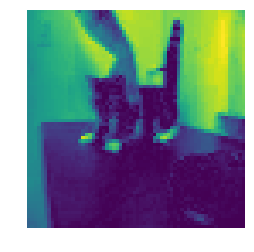

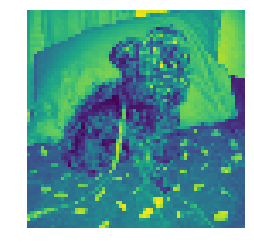

In [4]:
# Examine first cat and first dog color images
show_color_image(cats_1000_64_64_3[0,:,:,2])
show_color_image(dogs_1000_64_64_3[0,:,:,2])

In [5]:
# importing higher resolution, greyscale files
# we're working with them for the 2 neural nets preceding the convolutional neural net to test benchmarks for models
cats_1000_128_128_1 = np.load('cats_dogs_images/greyscale/cats_1000_128_128_1.npy')
dogs_1000_128_128_1 = np.load('cats_dogs_images/greyscale/dogs_1000_128_128_1.npy')

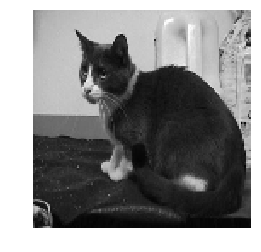

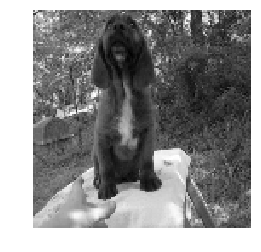

In [6]:
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_128_128_1[4,:,:,0])
show_grayscale_image(dogs_1000_128_128_1[5,:,:,0])

In [10]:
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_128_128_1, dogs_1000_128_128_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,128*128) # note coversion to 16384 (128x128) inputs
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)
X_cat_dog.shape #check data shape

(2000, 16384)

In [11]:
y_cat_dog.shape #check target data shape

(2000,)

In [12]:
#Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1)) 
X_cat_dog_min_max = scaler.transform(X_cat_dog)

In [13]:
#Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import RobustScaler
scaler2 = RobustScaler()
scaler2.fit(np.array([0., 255.]).reshape(-1,1)) 
X_cat_dog_robust_scale = scaler2.transform(X_cat_dog)

In [14]:
X_cat_dog_min_max.shape

(2000, 16384)

In [15]:
X_cat_dog_robust_scale.shape

(2000, 16384)

In [16]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

# Random splitting of the data in to training (80%) and test (20%)  
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = \
    train_test_split(X_cat_dog_robust_scale, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [17]:
X_train_m1.shape

(1600, 16384)

In [18]:
y_train_m1.shape

(1600,)

In [19]:
X_cat_dog_m3 = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 
#X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 16384 (128x128) inputs
#Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog_m3 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)
X_cat_dog_m3.shape #check data shape

(2000, 64, 64, 3)

In [20]:
y_cat_dog_m3.shape #check data shape

(2000,)

In [21]:
# test-train split   
X_m3, X_test_m3, Y_m3, Y_test_m3 = train_test_split(X_cat_dog_m3, y_cat_dog_m3, test_size=0.2, random_state=42)

# encode the Ys
Y_m3 = to_categorical(Y_m3, 2)
Y_test_m3 = to_categorical(Y_test_m3, 2)

In [22]:
X_m3.shape

(1600, 64, 64, 3)

In [23]:
Y_m3.shape

(1600, 2)

In [24]:
# setup - define neuron layer
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [25]:
#set height & width
height = 128
width = 128 

# 300 and 100 nodes for layers 1 and 2 as used with MNIST from Geron
n_hidden1 = 300
n_hidden2 = 100
n_hidden3 = 50
n_hidden4 = 500

channels = 1  # When working with color images use channels = 3

n_inputs = height * width

#CatsDogs# Has two output values # MNIST had ten digits n_outputs = 10  
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

reset_graph()

# dnn... Deep neural network model from Geron Chapter 10
# Note that this model makes no use of the fact that we have
# pixel data arranged in rows and columns
# So a 64x64 matrix of raster values becomes a vector of 4096 input variables
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [31]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### First Neural Net: 50 Epochs, Min-Max Scaler

In [32]:
%%time

init = tf.global_variables_initializer()    

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train_m1.shape[0] // batch_size):
            X_batch = X_train_m1[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train_m1[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_m1, y: y_test_m1})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_catdog_model_m1")

0 Train accuracy: 0.61 Test accuracy: 0.485
1 Train accuracy: 0.6 Test accuracy: 0.485
2 Train accuracy: 0.61 Test accuracy: 0.485
3 Train accuracy: 0.62 Test accuracy: 0.495
4 Train accuracy: 0.62 Test accuracy: 0.4925
5 Train accuracy: 0.63 Test accuracy: 0.5
6 Train accuracy: 0.65 Test accuracy: 0.5025
7 Train accuracy: 0.68 Test accuracy: 0.505
8 Train accuracy: 0.67 Test accuracy: 0.5175
9 Train accuracy: 0.68 Test accuracy: 0.5125
10 Train accuracy: 0.7 Test accuracy: 0.5325
11 Train accuracy: 0.72 Test accuracy: 0.5325
12 Train accuracy: 0.69 Test accuracy: 0.5275
13 Train accuracy: 0.69 Test accuracy: 0.5225
14 Train accuracy: 0.69 Test accuracy: 0.525
15 Train accuracy: 0.7 Test accuracy: 0.54
16 Train accuracy: 0.74 Test accuracy: 0.55
17 Train accuracy: 0.69 Test accuracy: 0.535
18 Train accuracy: 0.73 Test accuracy: 0.53
19 Train accuracy: 0.66 Test accuracy: 0.525
20 Train accuracy: 0.77 Test accuracy: 0.545
21 Train accuracy: 0.71 Test accuracy: 0.54
22 Train accuracy: 0.

### Second Neural Net: 50 Epochs, Robust Scaler

In [34]:
%%time

init = tf.global_variables_initializer()    

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train_m2.shape[0] // batch_size):
            X_batch = X_train_m2[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train_m2[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_m2, y: y_test_m2})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_catdog_model_m2")

0 Train accuracy: 0.79 Test accuracy: 0.505
1 Train accuracy: 0.91 Test accuracy: 0.51
2 Train accuracy: 0.92 Test accuracy: 0.525
3 Train accuracy: 0.94 Test accuracy: 0.5375
4 Train accuracy: 0.95 Test accuracy: 0.5375
5 Train accuracy: 0.97 Test accuracy: 0.5425
6 Train accuracy: 0.97 Test accuracy: 0.5425
7 Train accuracy: 0.97 Test accuracy: 0.55
8 Train accuracy: 1.0 Test accuracy: 0.55
9 Train accuracy: 1.0 Test accuracy: 0.5575
10 Train accuracy: 1.0 Test accuracy: 0.5525
11 Train accuracy: 1.0 Test accuracy: 0.5575
12 Train accuracy: 1.0 Test accuracy: 0.5625
13 Train accuracy: 1.0 Test accuracy: 0.5575
14 Train accuracy: 1.0 Test accuracy: 0.5625
15 Train accuracy: 1.0 Test accuracy: 0.5625
16 Train accuracy: 1.0 Test accuracy: 0.56
17 Train accuracy: 1.0 Test accuracy: 0.56
18 Train accuracy: 1.0 Test accuracy: 0.56
19 Train accuracy: 1.0 Test accuracy: 0.5575
20 Train accuracy: 1.0 Test accuracy: 0.5525
21 Train accuracy: 1.0 Test accuracy: 0.5475
22 Train accuracy: 1.0 Tes

In [37]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 3

###################################
# Image transformations
###################################

# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [38]:
X_test_m3.shape

(400, 64, 64, 3)

### Convolutional Neural Net: 100 Epochs, Many Different Layers

In [39]:
###################################
# Define network architecture
###################################

import tflearn 

# Inputs are the 64x64 images with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_6.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

In [70]:
print(X_m3[0].shape)


(64, 64, 3)


In [45]:
Y_m3[0:20]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [47]:
%%time
###################################
# Train model for 100 epochs
###################################
model.fit(X_m3, Y_m3, validation_set=(X_test_m3, Y_test_m3), batch_size=500,
      n_epoch=100, run_id='model_cat_dog_6', show_metric=True)

model.save('model_cat_dog_6_final.tflearn')

Training Step: 399  | total loss: 0.17526 | time: 15.045s
| Adam | epoch: 100 | loss: 0.17526 - Accuracy: 0.9374 -- iter: 1500/1600
Training Step: 400  | total loss: 0.17425 | time: 17.848s
| Adam | epoch: 100 | loss: 0.17425 - Accuracy: 0.9387 | val_loss: 0.59683 - val_acc: 0.7900 -- iter: 1600/1600
--
CPU times: user 3h 13min 9s, sys: 26min 26s, total: 3h 39min 36s
Wall time: 38min 39s
